# Lab 5: Custom MLP + PyTorch with Full Visualization

In [1]:

import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

df = pd.read_csv('WineQT.csv')
X = df.drop('quality',axis=1).values
y = df['quality'].values - df['quality'].min()
sc = StandardScaler()
X = sc.fit_transform(X)
X_train,X_tmp,y_train,y_tmp = train_test_split(X,y,test_size=0.3,random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_tmp,y_tmp,test_size=0.5,random_state=42)

X_train = torch.tensor(X_train,dtype=torch.float32)
X_val = torch.tensor(X_val,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype=torch.long)
y_val = torch.tensor(y_val,dtype=torch.long)
y_test = torch.tensor(y_test,dtype=torch.long)


In [2]:

class Activation:
    @staticmethod
    def relu(x): return torch.maximum(x, torch.zeros_like(x))
    @staticmethod
    def relu_deriv(x): return (x>0).float()


In [3]:

class Loss:
    @staticmethod
    def softmax(x):
        ex = torch.exp(x - x.max(dim=0,keepdim=True).values)
        return ex / ex.sum(dim=0,keepdim=True)
    @staticmethod
    def cross_entropy(pred, y):
        return -torch.log(pred[y, torch.arange(y.shape[0])]).mean()
    @staticmethod
    def grad(pred, y):
        g = pred.clone()
        g[y, torch.arange(y.shape[0])] -= 1
        return g / y.shape[0]


In [ ]:

class CustomMLP:
    def __init__(self,sizes,lr=0.01):
        self.sizes=sizes; self.lr=lr
        self.W=[]; self.b=[]
        for i in range(len(sizes)-1):
            self.W.append(torch.randn(sizes[i+1],sizes[i])*np.sqrt(2/sizes[i]))
            self.b.append(torch.zeros(sizes[i+1],1))
    def forward(self,X):
        A=X.T; cache={'A0':A}
        for i in range(len(self.W)-1):
            Z=self.W[i]@A+self.b[i]
            A=Activation.relu(Z)
            cache[f'Z{i+1}']=Z; cache[f'A{i+1}']=A
        Z=self.W[-1]@A+self.b[-1]
        A=Loss.softmax(Z)
        cache[f'Z{len(self.W)}']=Z; cache[f'A{len(self.W)}']=A
        return A,cache
    def backward(self,cache,y):
        L=len(self.W)
        Aout=cache[f'A{L}']
        dZ=Loss.grad(Aout,y)
        for i in reversed(range(L)):
            A_prev=cache[f'A{i}']
            dW=dZ@A_prev.T
            db=dZ.sum(dim=1,keepdim=True)
            self.W[i]-=self.lr*dW
            self.b[i]-=self.lr*db
            if i>0:
                Z_prev=cache[f'Z{i}']
                dA=self.W[i].T@dZ
                dZ=dA*Activation.relu_deriv(Z_prev)
    def predict(self,X):
        A,_=self.forward(X)
        return A.argmax(dim=0)

In [5]:

mlp=CustomMLP([X_train.shape[1],32,16,6],lr=0.01)
losses=[]
val_accs=[]
for epoch in range(200):
    A,cache=mlp.forward(X_train)
    loss=float(Loss.cross_entropy(A,y_train))
    mlp.backward(cache,y_train)
    with torch.no_grad():
        pred=mlp.predict(X_val)
        acc=(pred==y_val).float().mean().item()
    losses.append(loss)
    val_accs.append(acc)


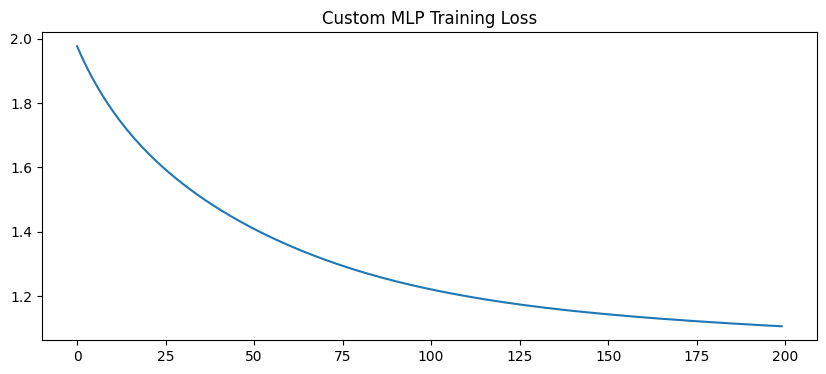

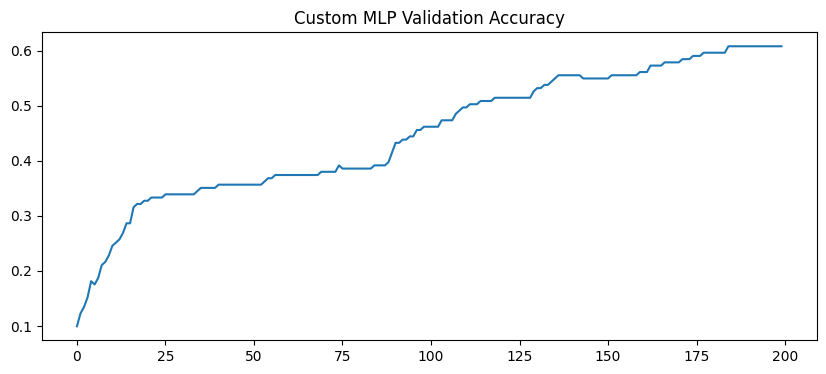

In [6]:

plt.figure(figsize=(10,4))
plt.plot(losses)
plt.title("Custom MLP Training Loss")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(val_accs)
plt.title("Custom MLP Validation Accuracy")
plt.show()


In [7]:

import torch.nn as nn
class PT(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(X_train.shape[1],32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,6)
        )
    def forward(self,x): return self.net(x)

pt=PT()
opt=torch.optim.Adam(pt.parameters())
crit=nn.CrossEntropyLoss()

pt_losses=[]
pt_accs=[]

for e in range(200):
    opt.zero_grad()
    out=pt(X_train)
    loss=crit(out,y_train)
    loss.backward(); opt.step()
    with torch.no_grad():
        val=pt(X_val).argmax(dim=1)
        acc=(val==y_val).float().mean().item()
    pt_losses.append(loss.item())
    pt_accs.append(acc)


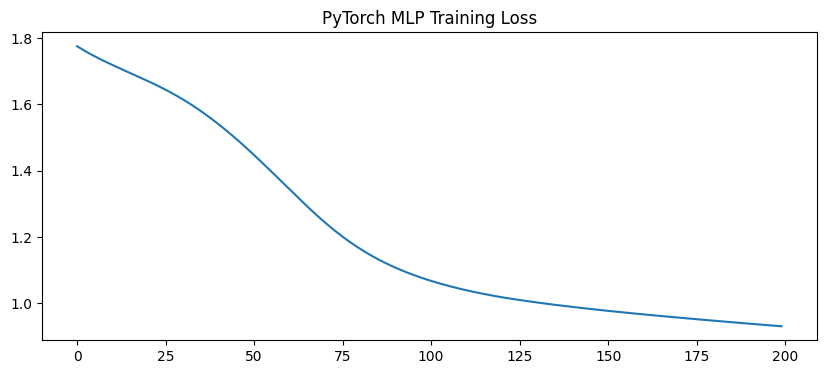

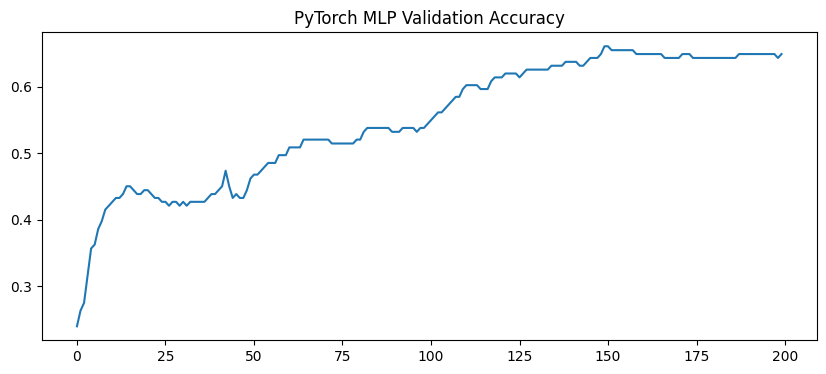

In [8]:

plt.figure(figsize=(10,4))
plt.plot(pt_losses)
plt.title("PyTorch MLP Training Loss")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pt_accs)
plt.title("PyTorch MLP Validation Accuracy")
plt.show()


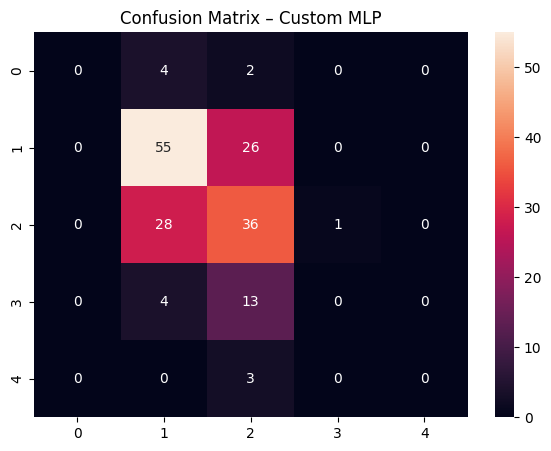

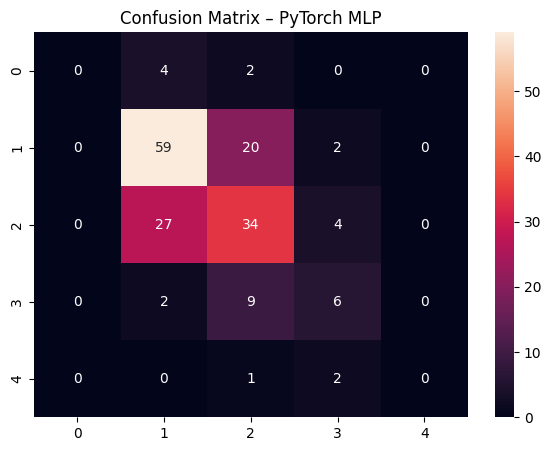

In [9]:

y_pred_custom = mlp.predict(X_test)
y_pred_pt = pt(X_test).argmax(dim=1)

cm_custom = confusion_matrix(y_test, y_pred_custom)
cm_pt = confusion_matrix(y_test, y_pred_pt)

plt.figure(figsize=(7,5))
sns.heatmap(cm_custom, annot=True, fmt='d')
plt.title("Confusion Matrix – Custom MLP")
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(cm_pt, annot=True, fmt='d')
plt.title("Confusion Matrix – PyTorch MLP")
plt.show()


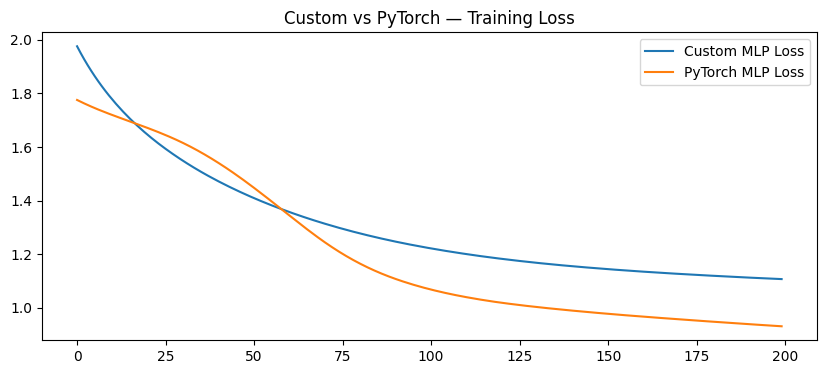

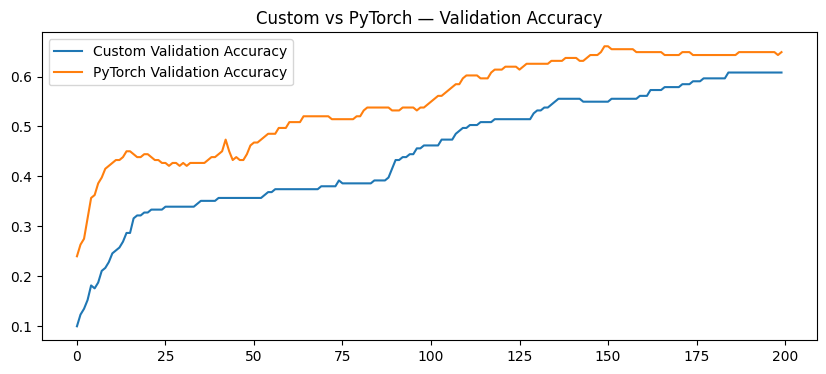

In [10]:

# === Combined Comparison Plots ===

plt.figure(figsize=(10,4))
plt.plot(losses, label="Custom MLP Loss")
plt.plot(pt_losses, label="PyTorch MLP Loss")
plt.title("Custom vs PyTorch — Training Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(val_accs, label="Custom Validation Accuracy")
plt.plot(pt_accs, label="PyTorch Validation Accuracy")
plt.title("Custom vs PyTorch — Validation Accuracy")
plt.legend()
plt.show()
